<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/PDBBind_Base_Model_Affi_NN_ity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyTDC rdkit-pypi torch-geometric pandas tqdm deepchem
!pip install fair-esm biopython torch
# PyTDC: Loading clean DTI datasets (like DAVIS)
# rdkit-pypi: Parsing drug SMILES and converting to molecule graphs
# torch-geometric: Building GNN architecture for drug inputs
# tqdm: Shows real-time progress for preprocessing steps like SMILES parsing)

  Using cached pytdc-1.1.15.tar.gz (154 kB)
  Preparing metadata (setup.py) ... done
  Using cached rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached deepchem-2.8.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB)
  Using cached dataclasses-0.6-py3-none-any.whl.metadata (3.0 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata (4.9 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached transformers-4.50.3-py3-none-any.whl.metadata (39 kB)
  Using cached cellxgene_census-1.15.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached gget-0.29.2-py3-none-any.whl.metadata (7.9 kB)
  Using cached rdkit-2023.9.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [1]:
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import deepchem as dc

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# 1. Load raw molecules from PDBBind
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    pdbbind_version='refined',
    splitter='random',
    reload=False
)
train_dataset, valid_dataset, test_dataset = datasets


In [3]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

154
19
20


In [4]:
iterator = 0
for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
    print("Features (X):", X)
    print(X[0][0])
    print("Label (y):", y)
    print("Weight (w):", w)
    print("ID:", ids)
    iterator += 1
    if iterator == 2:
      break  # Just show the first one

Features (X): [['/tmp/v2013-core/3muz/3muz_ligand.sdf'
  '/tmp/v2013-core/3muz/3muz_pocket.pdb']]
/tmp/v2013-core/3muz/3muz_ligand.sdf
Label (y): [-1.28467376]
Weight (w): [1.]
ID: ['3muz']
Features (X): [['/tmp/v2013-core/4djr/4djr_ligand.sdf'
  '/tmp/v2013-core/4djr/4djr_pocket.pdb']]
/tmp/v2013-core/4djr/4djr_ligand.sdf
Label (y): [2.31257507]
Weight (w): [1.]
ID: ['4djr']


In [5]:
import torch
import numpy as np
from rdkit import Chem
from torch_geometric.data import Data

def get_node_features(mol):
    all_node_feats = []
    for atom in mol.GetAtoms():
        node_feats = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),  # convert enum to int
            atom.GetIsAromatic(),
            atom.GetTotalNumHs(),
            atom.GetNumRadicalElectrons(),
            atom.IsInRing(),
            int(atom.GetChiralTag())  # convert enum to int
        ]
        all_node_feats.append(node_feats)
    return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol):
    all_edge_feats = []
    for bond in mol.GetBonds():
        edge_feats = [
            bond.GetBondTypeAsDouble(),
            bond.IsInRing()
        ]
        all_edge_feats += [edge_feats, edge_feats]  # Bidirectional edges
    return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]  # Bidirectional edges
    return torch.tensor(edge_indices, dtype=torch.long).t().contiguous()


In [6]:
from Bio import PDB
import torch
import esm

def extract_sequence_from_pdb(pdb_path):
    """Extracts the amino acid sequence from a PDB file using Biopython."""
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)

    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())

    return sequence

# Define amino acid to index mapping
aa_to_idx = {
    'A': 1,  # Alanine
    'C': 2,  # Cysteine
    'D': 3,  # Aspartic Acid
    'E': 4,  # Glutamic Acid
    'F': 5,  # Phenylalanine
    'G': 6,  # Glycine
    'H': 7,  # Histidine
    'I': 8,  # Isoleucine
    'K': 9,  # Lysine
    'L': 10, # Leucine
    'M': 11, # Methionine
    'N': 12, # Asparagine
    'P': 13, # Proline
    'Q': 14, # Glutamine
    'R': 15, # Arginine
    'S': 16, # Serine
    'T': 17, # Threonine
    'V': 18, # Valine
    'W': 19, # Tryptophan
    'Y': 20  # Tyrosine
}


def encode_sequence(seq, aa_to_idx, max_len=25):
    seq_idx = [aa_to_idx.get(aa, 0) for aa in seq]  # 0 for unknowns
    if len(seq_idx) < max_len:
        seq_idx += [0] * (max_len - len(seq_idx))
    else:
        seq_idx = seq_idx[:max_len]
    return seq_idx


In [7]:
example_mol = Chem.MolFromMolFile('/tmp/v2013-core/1e66/1e66_ligand.sdf')
print(example_mol)  # prints something like: <rdkit.Chem.rdchem.Mol object at 0x7f8a8c9a4d90>

print(get_node_features(example_mol))
print(get_edge_features(example_mol))
print(get_adjacency_info(example_mol))

tensor([[ 7.,  2.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 7.,  1.,  0.,  3.,  0.,  2.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  1.,  1.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  4.,  0.,  2.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  4.,  0.,  1.,  0.,  1.,  2.],
        [ 6.,  2.,  0.,  3.,  0.,  1.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  0.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  4.,  0.,  2.,  0.,  1.,  0.],
        [ 6.,  1.,  0.,  4.,  0.,  3.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  4.,  0.,  1.,  0.,  1.,  1.],
        [ 6.,  2.,  0.,  4.,  0.,  2.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  1.,  1.,  0.,  1.,  0.],
        [ 

[18:47:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [8]:
example_protein_path = "/tmp/v2013-core/1o3f/1o3f_pocket.pdb"  # Replace with your actual file
example_protein_sequence = extract_sequence_from_pdb(example_protein_path)
print("Sequence:", example_protein_sequence)

example_protein_embedding = encode_sequence(example_protein_sequence, aa_to_idx)
print("ESM Embedding shape:", example_protein_embedding)
example_protein_embedding

Sequence: FCHCDSCQGDSVSWGSGCAGVY
ESM Embedding shape: [5, 2, 7, 2, 3, 16, 2, 14, 6, 3, 16, 18, 16, 19, 6, 16, 6, 2, 1, 6, 18, 20, 0, 0, 0]


[5,
 2,
 7,
 2,
 3,
 16,
 2,
 14,
 6,
 3,
 16,
 18,
 16,
 19,
 6,
 16,
 6,
 2,
 1,
 6,
 18,
 20,
 0,
 0,
 0]

In [9]:
def t(dc_dataset):
    max_len = 0
    molecule_data = []

    for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
        protein_path = X[0][1]
        print(protein_path)


        protein_sequence = extract_sequence_from_pdb(protein_path)
        max_len = max(max_len, len(protein_sequence))

    return max_len
t(train_dataset)

/tmp/v2013-core/3muz/3muz_pocket.pdb
/tmp/v2013-core/4djr/4djr_pocket.pdb
/tmp/v2013-core/3g0w/3g0w_pocket.pdb
/tmp/v2013-core/2ole/2ole_pocket.pdb
/tmp/v2013-core/3myg/3myg_pocket.pdb
/tmp/v2013-core/3l4u/3l4u_pocket.pdb
/tmp/v2013-core/3fk1/3fk1_pocket.pdb
/tmp/v2013-core/1a30/1a30_pocket.pdb
/tmp/v2013-core/1oyt/1oyt_pocket.pdb
/tmp/v2013-core/3ozt/3ozt_pocket.pdb
/tmp/v2013-core/1mq6/1mq6_pocket.pdb
/tmp/v2013-core/3u9q/3u9q_pocket.pdb
/tmp/v2013-core/3nox/3nox_pocket.pdb
/tmp/v2013-core/1w3l/1w3l_pocket.pdb
/tmp/v2013-core/2zwz/2zwz_pocket.pdb
/tmp/v2013-core/1lol/1lol_pocket.pdb
/tmp/v2013-core/3ao4/3ao4_pocket.pdb
/tmp/v2013-core/2xb8/2xb8_pocket.pdb
/tmp/v2013-core/3bpc/3bpc_pocket.pdb
/tmp/v2013-core/1hfs/1hfs_pocket.pdb
/tmp/v2013-core/2yki/2yki_pocket.pdb
/tmp/v2013-core/1yc1/1yc1_pocket.pdb
/tmp/v2013-core/4de2/4de2_pocket.pdb
/tmp/v2013-core/2vw5/2vw5_pocket.pdb
/tmp/v2013-core/3ueu/3ueu_pocket.pdb
/tmp/v2013-core/1o3f/1o3f_pocket.pdb
/tmp/v2013-core/3kwa/3kwa_pocket.pdb
/

24

In [10]:
def process_deepchem_dataset(dc_dataset):
    molecule_data = []

    for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
        ligand_path = X[0][0]
        print(ligand_path)
        protein_path = X[0][1]
        print(protein_path)

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))

        if ligand_mol is None:
          print(f"Failed to load ligand molecule from {ligand_path}")
          continue  # Skip this sample

        node_feats = get_node_features(ligand_mol)
        edge_feats = get_edge_features(ligand_mol)
        edge_index = get_adjacency_info(ligand_mol)

        protein_sequence = extract_sequence_from_pdb(protein_path)
        target_features = encode_sequence(protein_sequence, aa_to_idx)
        target_features = torch.tensor(target_features, dtype=torch.long).unsqueeze(0)

        data = Data(
            x=node_feats,
            edge_index=edge_index,
            edge_attr=edge_feats,
            y=torch.tensor(y, dtype=torch.float)
        )
        data.target_features = target_features

        molecule_data.append(data)

    return molecule_data


In [11]:
train_graphs = process_deepchem_dataset(train_dataset)
valid_graphs = process_deepchem_dataset(valid_dataset)
test_graphs = process_deepchem_dataset(test_dataset)

# Create DataLoaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

/tmp/v2013-core/3muz/3muz_ligand.sdf
/tmp/v2013-core/3muz/3muz_pocket.pdb
/tmp/v2013-core/4djr/4djr_ligand.sdf
/tmp/v2013-core/4djr/4djr_pocket.pdb
/tmp/v2013-core/3g0w/3g0w_ligand.sdf
/tmp/v2013-core/3g0w/3g0w_pocket.pdb
/tmp/v2013-core/2ole/2ole_ligand.sdf
/tmp/v2013-core/2ole/2ole_pocket.pdb
/tmp/v2013-core/3myg/3myg_ligand.sdf
/tmp/v2013-core/3myg/3myg_pocket.pdb
/tmp/v2013-core/3l4u/3l4u_ligand.sdf
/tmp/v2013-core/3l4u/3l4u_pocket.pdb
/tmp/v2013-core/3fk1/3fk1_ligand.sdf
/tmp/v2013-core/3fk1/3fk1_pocket.pdb
/tmp/v2013-core/1a30/1a30_ligand.sdf
/tmp/v2013-core/1a30/1a30_pocket.pdb
/tmp/v2013-core/1oyt/1oyt_ligand.sdf
/tmp/v2013-core/1oyt/1oyt_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1oyt/1oyt_ligand.sdf
/tmp/v2013-core/3ozt/3ozt_ligand.sdf
/tmp/v2013-core/3ozt/3ozt_pocket.pdb
/tmp/v2013-core/1mq6/1mq6_ligand.sdf
/tmp/v2013-core/1mq6/1mq6_pocket.pdb
/tmp/v2013-core/3u9q/3u9q_ligand.sdf
/tmp/v2013-core/3u9q/3u9q_pocket.pdb
/tmp/v2013-core/3nox/3nox_ligand.sdf
/t

[18:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/1lol/1lol_ligand.sdf
/tmp/v2013-core/1lol/1lol_pocket.pdb
/tmp/v2013-core/3ao4/3ao4_ligand.sdf
/tmp/v2013-core/3ao4/3ao4_pocket.pdb
/tmp/v2013-core/2xb8/2xb8_ligand.sdf
/tmp/v2013-core/2xb8/2xb8_pocket.pdb
/tmp/v2013-core/3bpc/3bpc_ligand.sdf
/tmp/v2013-core/3bpc/3bpc_pocket.pdb
/tmp/v2013-core/1hfs/1hfs_ligand.sdf
/tmp/v2013-core/1hfs/1hfs_pocket.pdb
/tmp/v2013-core/2yki/2yki_ligand.sdf
/tmp/v2013-core/2yki/2yki_pocket.pdb
/tmp/v2013-core/1yc1/1yc1_ligand.sdf
/tmp/v2013-core/1yc1/1yc1_pocket.pdb
/tmp/v2013-core/4de2/4de2_ligand.sdf
/tmp/v2013-core/4de2/4de2_pocket.pdb
/tmp/v2013-core/2vw5/2vw5_ligand.sdf
/tmp/v2013-core/2vw5/2vw5_pocket.pdb
/tmp/v2013-core/3ueu/3ueu_ligand.sdf
/tmp/v2013-core/3ueu/3ueu_pocket.pdb
/tmp/v2013-core/1o3f/1o3f_ligand.sdf
/tmp/v2013-core/1o3f/1o3f_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1o3f/1o3f_ligand.sdf
/tmp/v2013-core/3kwa/3kwa_ligand.sdf
/tmp/v2013-core/3kwa/3kwa_pocket.pdb


[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/3su3/3su3_ligand.sdf
/tmp/v2013-core/3su3/3su3_pocket.pdb
/tmp/v2013-core/2gss/2gss_ligand.sdf
/tmp/v2013-core/2gss/2gss_pocket.pdb
/tmp/v2013-core/3ebp/3ebp_ligand.sdf
/tmp/v2013-core/3ebp/3ebp_pocket.pdb
/tmp/v2013-core/2obf/2obf_ligand.sdf
/tmp/v2013-core/2obf/2obf_pocket.pdb
/tmp/v2013-core/2xbv/2xbv_ligand.sdf
/tmp/v2013-core/2xbv/2xbv_pocket.pdb
/tmp/v2013-core/2pcp/2pcp_ligand.sdf
/tmp/v2013-core/2pcp/2pcp_pocket.pdb
/tmp/v2013-core/2ymd/2ymd_ligand.sdf
/tmp/v2013-core/2ymd/2ymd_pocket.pdb
/tmp/v2013-core/3g2n/3g2n_ligand.sdf
/tmp/v2013-core/3g2n/3g2n_pocket.pdb
/tmp/v2013-core/3g2z/3g2z_ligand.sdf
/tmp/v2013-core/3g2z/3g2z_pocket.pdb
/tmp/v2013-core/3ge7/3ge7_ligand.sdf
/tmp/v2013-core/3ge7/3ge7_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/3ge7/3ge7_ligand.sdf
/tmp/v2013-core/1e66/1e66_ligand.sdf
/tmp/v2013-core/1e66/1e66_pocket.pdb


[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/2brb/2brb_ligand.sdf
/tmp/v2013-core/2brb/2brb_pocket.pdb
/tmp/v2013-core/3gbb/3gbb_ligand.sdf
/tmp/v2013-core/3gbb/3gbb_pocket.pdb
/tmp/v2013-core/3vd4/3vd4_ligand.sdf
/tmp/v2013-core/3vd4/3vd4_pocket.pdb
/tmp/v2013-core/3f3a/3f3a_ligand.sdf
/tmp/v2013-core/3f3a/3f3a_pocket.pdb
/tmp/v2013-core/2pq9/2pq9_ligand.sdf
/tmp/v2013-core/2pq9/2pq9_pocket.pdb
/tmp/v2013-core/2vl4/2vl4_ligand.sdf
/tmp/v2013-core/2vl4/2vl4_pocket.pdb
/tmp/v2013-core/1os0/1os0_ligand.sdf
/tmp/v2013-core/1os0/1os0_pocket.pdb
/tmp/v2013-core/2qbr/2qbr_ligand.sdf
/tmp/v2013-core/2qbr/2qbr_pocket.pdb
/tmp/v2013-core/10gs/10gs_ligand.sdf
/tmp/v2013-core/10gs/10gs_pocket.pdb
/tmp/v2013-core/3lka/3lka_ligand.sdf
/tmp/v2013-core/3lka/3lka_pocket.pdb
/tmp/v2013-core/3jvs/3jvs_ligand.sdf
/tmp/v2013-core/3jvs/3jvs_pocket.pdb
/tmp/v2013-core/2v7a/2v7a_ligand.sdf
/tmp/v2013-core/2v7a/2v7a_pocket.pdb
/tmp/v2013-core/3ivg/3ivg_ligand.sdf
/tmp/v2013-core/3ivg/3ivg_pocket.pdb
/tmp/v2013-core/3uex/3uex_ligand.sdf
/

[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/3gy4/3gy4_ligand.sdf
/tmp/v2013-core/3gy4/3gy4_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/3gy4/3gy4_ligand.sdf
/tmp/v2013-core/3ov1/3ov1_ligand.sdf
/tmp/v2013-core/3ov1/3ov1_pocket.pdb
/tmp/v2013-core/3dd0/3dd0_ligand.sdf
/tmp/v2013-core/3dd0/3dd0_pocket.pdb
/tmp/v2013-core/2zcr/2zcr_ligand.sdf
/tmp/v2013-core/2zcr/2zcr_pocket.pdb
/tmp/v2013-core/1f8c/1f8c_ligand.sdf
/tmp/v2013-core/1f8c/1f8c_pocket.pdb
/tmp/v2013-core/2x8z/2x8z_ligand.sdf
/tmp/v2013-core/2x8z/2x8z_pocket.pdb
/tmp/v2013-core/1jyq/1jyq_ligand.sdf
/tmp/v2013-core/1jyq/1jyq_pocket.pdb
/tmp/v2013-core/3gcs/3gcs_ligand.sdf
/tmp/v2013-core/3gcs/3gcs_pocket.pdb
/tmp/v2013-core/2cet/2cet_ligand.sdf
/tmp/v2013-core/2cet/2cet_pocket.pdb
/tmp/v2013-core/1gpk/1gpk_ligand.sdf
/tmp/v2013-core/1gpk/1gpk_pocket.pdb
/tmp/v2013-core/3huc/3huc_ligand.sdf
/tmp/v2013-core/3huc/3huc_pocket.pdb
/tmp/v2013-core/3mss/3mss_ligand.sdf
/tmp/v2013-core/3mss/3mss_pocket.pdb
/tmp/v2013-core/2weg/2weg_ligand.sdf
/t

[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Explicit valence for atom # 2 C greater than permitted
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:33] Warning: molecule is tagged

/tmp/v2013-core/3imc/3imc_ligand.sdf
/tmp/v2013-core/3imc/3imc_pocket.pdb
/tmp/v2013-core/2zxd/2zxd_ligand.sdf
/tmp/v2013-core/2zxd/2zxd_pocket.pdb
/tmp/v2013-core/1p1q/1p1q_ligand.sdf
/tmp/v2013-core/1p1q/1p1q_pocket.pdb
/tmp/v2013-core/1lor/1lor_ligand.sdf
/tmp/v2013-core/1lor/1lor_pocket.pdb
/tmp/v2013-core/1sln/1sln_ligand.sdf
/tmp/v2013-core/1sln/1sln_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1sln/1sln_ligand.sdf
/tmp/v2013-core/1f8d/1f8d_ligand.sdf
/tmp/v2013-core/1f8d/1f8d_pocket.pdb
/tmp/v2013-core/3su5/3su5_ligand.sdf
/tmp/v2013-core/3su5/3su5_pocket.pdb
/tmp/v2013-core/3k5v/3k5v_ligand.sdf
/tmp/v2013-core/3k5v/3k5v_pocket.pdb
/tmp/v2013-core/3n86/3n86_ligand.sdf
/tmp/v2013-core/3n86/3n86_pocket.pdb
/tmp/v2013-core/2y5h/2y5h_ligand.sdf
/tmp/v2013-core/2y5h/2y5h_pocket.pdb
/tmp/v2013-core/2fvd/2fvd_ligand.sdf
/tmp/v2013-core/2fvd/2fvd_pocket.pdb


[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Explicit valence for atom # 23 C greater than permitted
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagge

/tmp/v2013-core/1z95/1z95_ligand.sdf
/tmp/v2013-core/1z95/1z95_pocket.pdb
/tmp/v2013-core/4gqq/4gqq_ligand.sdf
/tmp/v2013-core/4gqq/4gqq_pocket.pdb
/tmp/v2013-core/2iwx/2iwx_ligand.sdf
/tmp/v2013-core/2iwx/2iwx_pocket.pdb
/tmp/v2013-core/2r23/2r23_ligand.sdf
/tmp/v2013-core/2r23/2r23_pocket.pdb
/tmp/v2013-core/3fv1/3fv1_ligand.sdf
/tmp/v2013-core/3fv1/3fv1_pocket.pdb
/tmp/v2013-core/3b3w/3b3w_ligand.sdf
/tmp/v2013-core/3b3w/3b3w_pocket.pdb
/tmp/v2013-core/3b68/3b68_ligand.sdf
/tmp/v2013-core/3b68/3b68_pocket.pdb
/tmp/v2013-core/1kel/1kel_ligand.sdf
/tmp/v2013-core/1kel/1kel_pocket.pdb
/tmp/v2013-core/3f3e/3f3e_ligand.sdf
/tmp/v2013-core/3f3e/3f3e_pocket.pdb
/tmp/v2013-core/2g70/2g70_ligand.sdf
/tmp/v2013-core/2g70/2g70_pocket.pdb
/tmp/v2013-core/1u1b/1u1b_ligand.sdf
/tmp/v2013-core/1u1b/1u1b_pocket.pdb
/tmp/v2013-core/3n7a/3n7a_ligand.sdf
/tmp/v2013-core/3n7a/3n7a_pocket.pdb
/tmp/v2013-core/1q8u/1q8u_ligand.sdf
/tmp/v2013-core/1q8u/1q8u_pocket.pdb
/tmp/v2013-core/2p4y/2p4y_ligand.sdf
/

[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/3nq3/3nq3_ligand.sdf
/tmp/v2013-core/3nq3/3nq3_pocket.pdb
/tmp/v2013-core/1sqa/1sqa_ligand.sdf
/tmp/v2013-core/1sqa/1sqa_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1sqa/1sqa_ligand.sdf
/tmp/v2013-core/1n1m/1n1m_ligand.sdf
/tmp/v2013-core/1n1m/1n1m_pocket.pdb
/tmp/v2013-core/2zx6/2zx6_ligand.sdf
/tmp/v2013-core/2zx6/2zx6_pocket.pdb
/tmp/v2013-core/2qft/2qft_ligand.sdf
/tmp/v2013-core/2qft/2qft_pocket.pdb
/tmp/v2013-core/2d1o/2d1o_ligand.sdf
/tmp/v2013-core/2d1o/2d1o_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/2d1o/2d1o_ligand.sdf
/tmp/v2013-core/2hb1/2hb1_ligand.sdf
/tmp/v2013-core/2hb1/2hb1_pocket.pdb
/tmp/v2013-core/2wbg/2wbg_ligand.sdf
/tmp/v2013-core/2wbg/2wbg_pocket.pdb
/tmp/v2013-core/3pxf/3pxf_ligand.sdf
/tmp/v2013-core/3pxf/3pxf_pocket.pdb
/tmp/v2013-core/2vot/2vot_ligand.sdf
/tmp/v2013-core/2vot/2vot_pocket.pdb


[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Explicit valence for atom # 26 C greater than permitted
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Explicit valence for atom # 28 C greater than permitted
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not

/tmp/v2013-core/3gnw/3gnw_ligand.sdf
/tmp/v2013-core/3gnw/3gnw_pocket.pdb
/tmp/v2013-core/3kgp/3kgp_ligand.sdf
/tmp/v2013-core/3kgp/3kgp_pocket.pdb
/tmp/v2013-core/1n2v/1n2v_ligand.sdf
/tmp/v2013-core/1n2v/1n2v_pocket.pdb
/tmp/v2013-core/3bfu/3bfu_ligand.sdf
/tmp/v2013-core/3bfu/3bfu_pocket.pdb
/tmp/v2013-core/3fcq/3fcq_ligand.sdf
/tmp/v2013-core/3fcq/3fcq_pocket.pdb
/tmp/v2013-core/1qi0/1qi0_ligand.sdf
/tmp/v2013-core/1qi0/1qi0_pocket.pdb
/tmp/v2013-core/2x0y/2x0y_ligand.sdf
/tmp/v2013-core/2x0y/2x0y_pocket.pdb
/tmp/v2013-core/3cyx/3cyx_ligand.sdf
/tmp/v2013-core/3cyx/3cyx_pocket.pdb
/tmp/v2013-core/3ag9/3ag9_ligand.sdf
/tmp/v2013-core/3ag9/3ag9_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/3ag9/3ag9_ligand.sdf
/tmp/v2013-core/3mfv/3mfv_ligand.sdf
/tmp/v2013-core/3mfv/3mfv_pocket.pdb
/tmp/v2013-core/2zcq/2zcq_ligand.sdf
/tmp/v2013-core/2zcq/2zcq_pocket.pdb
/tmp/v2013-core/1o5b/1o5b_ligand.sdf
/tmp/v2013-core/1o5b/1o5b_pocket.pdb
Failed to load ligand molecule from /tm

[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/3f17/3f17_ligand.sdf
/tmp/v2013-core/3f17/3f17_pocket.pdb
/tmp/v2013-core/3uri/3uri_ligand.sdf
/tmp/v2013-core/3uri/3uri_pocket.pdb
/tmp/v2013-core/2v00/2v00_ligand.sdf
/tmp/v2013-core/2v00/2v00_pocket.pdb
/tmp/v2013-core/3cj2/3cj2_ligand.sdf
/tmp/v2013-core/3cj2/3cj2_pocket.pdb
/tmp/v2013-core/3vh9/3vh9_ligand.sdf
/tmp/v2013-core/3vh9/3vh9_pocket.pdb
/tmp/v2013-core/1vso/1vso_ligand.sdf
/tmp/v2013-core/1vso/1vso_pocket.pdb
/tmp/v2013-core/4djv/4djv_ligand.sdf
/tmp/v2013-core/4djv/4djv_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/4djv/4djv_ligand.sdf
/tmp/v2013-core/3f80/3f80_ligand.sdf
/tmp/v2013-core/3f80/3f80_pocket.pdb
/tmp/v2013-core/2jdm/2jdm_ligand.sdf
/tmp/v2013-core/2jdm/2jdm_pocket.pdb
/tmp/v2013-core/2jdu/2jdu_ligand.sdf
/tmp/v2013-core/2jdu/2jdu_pocket.pdb
/tmp/v2013-core/3utu/3utu_ligand.sdf
/tmp/v2013-core/3utu/3utu_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/3utu/3utu_ligand.sdf
/tmp/v2013-core/1zea/1zea_ligand.sdf
/tm

[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Explicit valence for atom # 4 C greater than permitted
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged

/tmp/v2013-core/4gid/4gid_ligand.sdf
/tmp/v2013-core/4gid/4gid_pocket.pdb
/tmp/v2013-core/3muz/3muz_ligand.sdf
/tmp/v2013-core/3muz/3muz_pocket.pdb
/tmp/v2013-core/4djr/4djr_ligand.sdf
/tmp/v2013-core/4djr/4djr_pocket.pdb
/tmp/v2013-core/3g0w/3g0w_ligand.sdf
/tmp/v2013-core/3g0w/3g0w_pocket.pdb
/tmp/v2013-core/2ole/2ole_ligand.sdf
/tmp/v2013-core/2ole/2ole_pocket.pdb
/tmp/v2013-core/3myg/3myg_ligand.sdf
/tmp/v2013-core/3myg/3myg_pocket.pdb
/tmp/v2013-core/3l4u/3l4u_ligand.sdf
/tmp/v2013-core/3l4u/3l4u_pocket.pdb
/tmp/v2013-core/3fk1/3fk1_ligand.sdf
/tmp/v2013-core/3fk1/3fk1_pocket.pdb
/tmp/v2013-core/1a30/1a30_ligand.sdf
/tmp/v2013-core/1a30/1a30_pocket.pdb
/tmp/v2013-core/1oyt/1oyt_ligand.sdf
/tmp/v2013-core/1oyt/1oyt_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1oyt/1oyt_ligand.sdf
/tmp/v2013-core/3ozt/3ozt_ligand.sdf
/tmp/v2013-core/3ozt/3ozt_pocket.pdb
/tmp/v2013-core/1mq6/1mq6_ligand.sdf
/tmp/v2013-core/1mq6/1mq6_pocket.pdb
/tmp/v2013-core/3u9q/3u9q_ligand.sdf
/t

[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/2zwz/2zwz_ligand.sdf
/tmp/v2013-core/2zwz/2zwz_pocket.pdb
/tmp/v2013-core/1lol/1lol_ligand.sdf
/tmp/v2013-core/1lol/1lol_pocket.pdb
/tmp/v2013-core/3ao4/3ao4_ligand.sdf
/tmp/v2013-core/3ao4/3ao4_pocket.pdb
/tmp/v2013-core/2xb8/2xb8_ligand.sdf
/tmp/v2013-core/2xb8/2xb8_pocket.pdb
/tmp/v2013-core/3bpc/3bpc_ligand.sdf
/tmp/v2013-core/3bpc/3bpc_pocket.pdb
/tmp/v2013-core/1hfs/1hfs_ligand.sdf
/tmp/v2013-core/1hfs/1hfs_pocket.pdb
/tmp/v2013-core/2yki/2yki_ligand.sdf
/tmp/v2013-core/2yki/2yki_pocket.pdb
/tmp/v2013-core/1yc1/1yc1_ligand.sdf
/tmp/v2013-core/1yc1/1yc1_pocket.pdb
/tmp/v2013-core/4de2/4de2_ligand.sdf
/tmp/v2013-core/4de2/4de2_pocket.pdb
/tmp/v2013-core/2vw5/2vw5_ligand.sdf
/tmp/v2013-core/2vw5/2vw5_pocket.pdb
/tmp/v2013-core/3ueu/3ueu_ligand.sdf
/tmp/v2013-core/3ueu/3ueu_pocket.pdb
/tmp/v2013-core/1o3f/1o3f_ligand.sdf
/tmp/v2013-core/1o3f/1o3f_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1o3f/1o3f_ligand.sdf
/tmp/v2013-core/3kwa/3kwa_ligand.sdf
/t

[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/2brb/2brb_ligand.sdf
/tmp/v2013-core/2brb/2brb_pocket.pdb
/tmp/v2013-core/3gbb/3gbb_ligand.sdf
/tmp/v2013-core/3gbb/3gbb_pocket.pdb
/tmp/v2013-core/3vd4/3vd4_ligand.sdf
/tmp/v2013-core/3vd4/3vd4_pocket.pdb
/tmp/v2013-core/3f3a/3f3a_ligand.sdf
/tmp/v2013-core/3f3a/3f3a_pocket.pdb
/tmp/v2013-core/2pq9/2pq9_ligand.sdf
/tmp/v2013-core/2pq9/2pq9_pocket.pdb
/tmp/v2013-core/2vl4/2vl4_ligand.sdf
/tmp/v2013-core/2vl4/2vl4_pocket.pdb
/tmp/v2013-core/1os0/1os0_ligand.sdf
/tmp/v2013-core/1os0/1os0_pocket.pdb
/tmp/v2013-core/2qbr/2qbr_ligand.sdf
/tmp/v2013-core/2qbr/2qbr_pocket.pdb
/tmp/v2013-core/10gs/10gs_ligand.sdf
/tmp/v2013-core/10gs/10gs_pocket.pdb
/tmp/v2013-core/3lka/3lka_ligand.sdf
/tmp/v2013-core/3lka/3lka_pocket.pdb
/tmp/v2013-core/3jvs/3jvs_ligand.sdf
/tmp/v2013-core/3jvs/3jvs_pocket.pdb
/tmp/v2013-core/2v7a/2v7a_ligand.sdf
/tmp/v2013-core/2v7a/2v7a_pocket.pdb
/tmp/v2013-core/3ivg/3ivg_ligand.sdf
/tmp/v2013-core/3ivg/3ivg_pocket.pdb
/tmp/v2013-core/3uex/3uex_ligand.sdf
/

[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/3mss/3mss_ligand.sdf
/tmp/v2013-core/3mss/3mss_pocket.pdb
/tmp/v2013-core/2weg/2weg_ligand.sdf
/tmp/v2013-core/2weg/2weg_pocket.pdb
/tmp/v2013-core/3coy/3coy_ligand.sdf
/tmp/v2013-core/3coy/3coy_pocket.pdb
/tmp/v2013-core/3imc/3imc_ligand.sdf
/tmp/v2013-core/3imc/3imc_pocket.pdb
/tmp/v2013-core/2zxd/2zxd_ligand.sdf
/tmp/v2013-core/2zxd/2zxd_pocket.pdb
/tmp/v2013-core/1p1q/1p1q_ligand.sdf
/tmp/v2013-core/1p1q/1p1q_pocket.pdb
/tmp/v2013-core/1lor/1lor_ligand.sdf
/tmp/v2013-core/1lor/1lor_pocket.pdb
/tmp/v2013-core/1sln/1sln_ligand.sdf
/tmp/v2013-core/1sln/1sln_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1sln/1sln_ligand.sdf
/tmp/v2013-core/1f8d/1f8d_ligand.sdf
/tmp/v2013-core/1f8d/1f8d_pocket.pdb
/tmp/v2013-core/3su5/3su5_ligand.sdf
/tmp/v2013-core/3su5/3su5_pocket.pdb
/tmp/v2013-core/3k5v/3k5v_ligand.sdf
/tmp/v2013-core/3k5v/3k5v_pocket.pdb
/tmp/v2013-core/3n86/3n86_ligand.sdf
/tmp/v2013-core/3n86/3n86_pocket.pdb
/tmp/v2013-core/2y5h/2y5h_ligand.sdf
/t

[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:35] Explicit valence for atom # 23 C greater than permitted
[18:47:35] Warning: molecule is tagge

/tmp/v2013-core/2fvd/2fvd_ligand.sdf
/tmp/v2013-core/2fvd/2fvd_pocket.pdb
/tmp/v2013-core/1z95/1z95_ligand.sdf
/tmp/v2013-core/1z95/1z95_pocket.pdb
/tmp/v2013-core/4gqq/4gqq_ligand.sdf
/tmp/v2013-core/4gqq/4gqq_pocket.pdb
/tmp/v2013-core/2iwx/2iwx_ligand.sdf
/tmp/v2013-core/2iwx/2iwx_pocket.pdb
/tmp/v2013-core/2r23/2r23_ligand.sdf
/tmp/v2013-core/2r23/2r23_pocket.pdb
/tmp/v2013-core/3fv1/3fv1_ligand.sdf
/tmp/v2013-core/3fv1/3fv1_pocket.pdb
/tmp/v2013-core/3b3w/3b3w_ligand.sdf
/tmp/v2013-core/3b3w/3b3w_pocket.pdb
/tmp/v2013-core/3b68/3b68_ligand.sdf
/tmp/v2013-core/3b68/3b68_pocket.pdb
/tmp/v2013-core/1kel/1kel_ligand.sdf
/tmp/v2013-core/1kel/1kel_pocket.pdb
/tmp/v2013-core/3f3e/3f3e_ligand.sdf
/tmp/v2013-core/3f3e/3f3e_pocket.pdb
/tmp/v2013-core/2g70/2g70_ligand.sdf
/tmp/v2013-core/2g70/2g70_pocket.pdb
/tmp/v2013-core/1u1b/1u1b_ligand.sdf
/tmp/v2013-core/1u1b/1u1b_pocket.pdb
/tmp/v2013-core/3n7a/3n7a_ligand.sdf
/tmp/v2013-core/3n7a/3n7a_pocket.pdb
/tmp/v2013-core/1q8u/1q8u_ligand.sdf
/

[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/2zx6/2zx6_ligand.sdf
/tmp/v2013-core/2zx6/2zx6_pocket.pdb
/tmp/v2013-core/2qft/2qft_ligand.sdf
/tmp/v2013-core/2qft/2qft_pocket.pdb
/tmp/v2013-core/2d1o/2d1o_ligand.sdf
/tmp/v2013-core/2d1o/2d1o_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/2d1o/2d1o_ligand.sdf
/tmp/v2013-core/2hb1/2hb1_ligand.sdf
/tmp/v2013-core/2hb1/2hb1_pocket.pdb
/tmp/v2013-core/2wbg/2wbg_ligand.sdf
/tmp/v2013-core/2wbg/2wbg_pocket.pdb
/tmp/v2013-core/3pxf/3pxf_ligand.sdf
/tmp/v2013-core/3pxf/3pxf_pocket.pdb
/tmp/v2013-core/2vot/2vot_ligand.sdf
/tmp/v2013-core/2vot/2vot_pocket.pdb
/tmp/v2013-core/3gnw/3gnw_ligand.sdf
/tmp/v2013-core/3gnw/3gnw_pocket.pdb
/tmp/v2013-core/3kgp/3kgp_ligand.sdf
/tmp/v2013-core/3kgp/3kgp_pocket.pdb
/tmp/v2013-core/1n2v/1n2v_ligand.sdf
/tmp/v2013-core/1n2v/1n2v_pocket.pdb
/tmp/v2013-core/3bfu/3bfu_ligand.sdf
/tmp/v2013-core/3bfu/3bfu_pocket.pdb
/tmp/v2013-core/3fcq/3fcq_ligand.sdf
/tmp/v2013-core/3fcq/3fcq_pocket.pdb
/tmp/v2013-core/1qi0/1qi0_ligand.sdf
/t

[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Explicit valence for atom # 28 C greater than permitted
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagge

/tmp/v2013-core/3cyx/3cyx_ligand.sdf
/tmp/v2013-core/3cyx/3cyx_pocket.pdb
/tmp/v2013-core/3ag9/3ag9_ligand.sdf
/tmp/v2013-core/3ag9/3ag9_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/3ag9/3ag9_ligand.sdf
/tmp/v2013-core/3mfv/3mfv_ligand.sdf
/tmp/v2013-core/3mfv/3mfv_pocket.pdb
/tmp/v2013-core/2zcq/2zcq_ligand.sdf
/tmp/v2013-core/2zcq/2zcq_pocket.pdb
/tmp/v2013-core/1o5b/1o5b_ligand.sdf
/tmp/v2013-core/1o5b/1o5b_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1o5b/1o5b_ligand.sdf
/tmp/v2013-core/2vvn/2vvn_ligand.sdf
/tmp/v2013-core/2vvn/2vvn_pocket.pdb
/tmp/v2013-core/3bkk/3bkk_ligand.sdf
/tmp/v2013-core/3bkk/3bkk_pocket.pdb
/tmp/v2013-core/3d4z/3d4z_ligand.sdf
/tmp/v2013-core/3d4z/3d4z_pocket.pdb
/tmp/v2013-core/1q8t/1q8t_ligand.sdf
/tmp/v2013-core/1q8t/1q8t_pocket.pdb
/tmp/v2013-core/2xhm/2xhm_ligand.sdf
/tmp/v2013-core/2xhm/2xhm_pocket.pdb
/tmp/v2013-core/3i3b/3i3b_ligand.sdf
/tmp/v2013-core/3i3b/3i3b_pocket.pdb
/tmp/v2013-core/3s8o/3s8o_ligand.sdf
/tm

[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Explicit valence for atom # 50 C greater than permitted
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Explicit valence for atom # 0 C greater than permitted
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not 

/tmp/v2013-core/1bcu/1bcu_ligand.sdf
/tmp/v2013-core/1bcu/1bcu_pocket.pdb
/tmp/v2013-core/4tmn/4tmn_ligand.sdf
/tmp/v2013-core/4tmn/4tmn_pocket.pdb
/tmp/v2013-core/2yge/2yge_ligand.sdf
/tmp/v2013-core/2yge/2yge_pocket.pdb
/tmp/v2013-core/3pe2/3pe2_ligand.sdf
/tmp/v2013-core/3pe2/3pe2_pocket.pdb
/tmp/v2013-core/2vo5/2vo5_ligand.sdf
/tmp/v2013-core/2vo5/2vo5_pocket.pdb
/tmp/v2013-core/3cft/3cft_ligand.sdf
/tmp/v2013-core/3cft/3cft_pocket.pdb
/tmp/v2013-core/2qbp/2qbp_ligand.sdf
/tmp/v2013-core/2qbp/2qbp_pocket.pdb
/tmp/v2013-core/1h23/1h23_ligand.sdf
/tmp/v2013-core/1h23/1h23_pocket.pdb
/tmp/v2013-core/4dew/4dew_ligand.sdf
/tmp/v2013-core/4dew/4dew_pocket.pdb
/tmp/v2013-core/3l3n/3l3n_ligand.sdf
/tmp/v2013-core/3l3n/3l3n_pocket.pdb
/tmp/v2013-core/1w3k/1w3k_ligand.sdf
/tmp/v2013-core/1w3k/1w3k_pocket.pdb
/tmp/v2013-core/3su2/3su2_ligand.sdf
/tmp/v2013-core/3su2/3su2_pocket.pdb
/tmp/v2013-core/1xd0/1xd0_ligand.sdf
/tmp/v2013-core/1xd0/1xd0_pocket.pdb
/tmp/v2013-core/3ehy/3ehy_ligand.sdf
/

[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/4gid/4gid_ligand.sdf
/tmp/v2013-core/4gid/4gid_pocket.pdb
/tmp/v2013-core/3muz/3muz_ligand.sdf
/tmp/v2013-core/3muz/3muz_pocket.pdb
/tmp/v2013-core/4djr/4djr_ligand.sdf
/tmp/v2013-core/4djr/4djr_pocket.pdb
/tmp/v2013-core/3g0w/3g0w_ligand.sdf
/tmp/v2013-core/3g0w/3g0w_pocket.pdb
/tmp/v2013-core/2ole/2ole_ligand.sdf
/tmp/v2013-core/2ole/2ole_pocket.pdb
/tmp/v2013-core/3myg/3myg_ligand.sdf
/tmp/v2013-core/3myg/3myg_pocket.pdb
/tmp/v2013-core/3l4u/3l4u_ligand.sdf
/tmp/v2013-core/3l4u/3l4u_pocket.pdb
/tmp/v2013-core/3fk1/3fk1_ligand.sdf
/tmp/v2013-core/3fk1/3fk1_pocket.pdb
/tmp/v2013-core/1a30/1a30_ligand.sdf
/tmp/v2013-core/1a30/1a30_pocket.pdb
/tmp/v2013-core/1oyt/1oyt_ligand.sdf
/tmp/v2013-core/1oyt/1oyt_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1oyt/1oyt_ligand.sdf
/tmp/v2013-core/3ozt/3ozt_ligand.sdf
/tmp/v2013-core/3ozt/3ozt_pocket.pdb
/tmp/v2013-core/1mq6/1mq6_ligand.sdf
/tmp/v2013-core/1mq6/1mq6_pocket.pdb
/tmp/v2013-core/3u9q/3u9q_ligand.sdf
/t

[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/3ueu/3ueu_ligand.sdf
/tmp/v2013-core/3ueu/3ueu_pocket.pdb
/tmp/v2013-core/1o3f/1o3f_ligand.sdf
/tmp/v2013-core/1o3f/1o3f_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1o3f/1o3f_ligand.sdf
/tmp/v2013-core/3kwa/3kwa_ligand.sdf
/tmp/v2013-core/3kwa/3kwa_pocket.pdb
/tmp/v2013-core/3su3/3su3_ligand.sdf
/tmp/v2013-core/3su3/3su3_pocket.pdb
/tmp/v2013-core/2gss/2gss_ligand.sdf
/tmp/v2013-core/2gss/2gss_pocket.pdb
/tmp/v2013-core/3ebp/3ebp_ligand.sdf
/tmp/v2013-core/3ebp/3ebp_pocket.pdb
/tmp/v2013-core/2obf/2obf_ligand.sdf
/tmp/v2013-core/2obf/2obf_pocket.pdb
/tmp/v2013-core/2xbv/2xbv_ligand.sdf
/tmp/v2013-core/2xbv/2xbv_pocket.pdb
/tmp/v2013-core/2pcp/2pcp_ligand.sdf
/tmp/v2013-core/2pcp/2pcp_pocket.pdb
/tmp/v2013-core/2ymd/2ymd_ligand.sdf
/tmp/v2013-core/2ymd/2ymd_pocket.pdb
/tmp/v2013-core/3g2n/3g2n_ligand.sdf
/tmp/v2013-core/3g2n/3g2n_pocket.pdb
/tmp/v2013-core/3g2z/3g2z_ligand.sdf
/tmp/v2013-core/3g2z/3g2z_pocket.pdb
/tmp/v2013-core/3ge7/3ge7_ligand.sdf
/t

[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Explicit valence for atom # 6 C greater than permitted
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged

/tmp/v2013-core/1os0/1os0_ligand.sdf
/tmp/v2013-core/1os0/1os0_pocket.pdb
/tmp/v2013-core/2qbr/2qbr_ligand.sdf
/tmp/v2013-core/2qbr/2qbr_pocket.pdb
/tmp/v2013-core/10gs/10gs_ligand.sdf
/tmp/v2013-core/10gs/10gs_pocket.pdb
/tmp/v2013-core/3lka/3lka_ligand.sdf
/tmp/v2013-core/3lka/3lka_pocket.pdb
/tmp/v2013-core/3jvs/3jvs_ligand.sdf
/tmp/v2013-core/3jvs/3jvs_pocket.pdb
/tmp/v2013-core/2v7a/2v7a_ligand.sdf
/tmp/v2013-core/2v7a/2v7a_pocket.pdb
/tmp/v2013-core/3ivg/3ivg_ligand.sdf
/tmp/v2013-core/3ivg/3ivg_pocket.pdb
/tmp/v2013-core/3uex/3uex_ligand.sdf
/tmp/v2013-core/3uex/3uex_pocket.pdb
/tmp/v2013-core/3nw9/3nw9_ligand.sdf
/tmp/v2013-core/3nw9/3nw9_pocket.pdb
/tmp/v2013-core/3gy4/3gy4_ligand.sdf
/tmp/v2013-core/3gy4/3gy4_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/3gy4/3gy4_ligand.sdf
/tmp/v2013-core/3ov1/3ov1_ligand.sdf
/tmp/v2013-core/3ov1/3ov1_pocket.pdb
/tmp/v2013-core/3dd0/3dd0_ligand.sdf
/tmp/v2013-core/3dd0/3dd0_pocket.pdb
/tmp/v2013-core/2zcr/2zcr_ligand.sdf
/t

[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/v2013-core/3mss/3mss_ligand.sdf
/tmp/v2013-core/3mss/3mss_pocket.pdb
/tmp/v2013-core/2weg/2weg_ligand.sdf
/tmp/v2013-core/2weg/2weg_pocket.pdb
/tmp/v2013-core/3coy/3coy_ligand.sdf
/tmp/v2013-core/3coy/3coy_pocket.pdb
/tmp/v2013-core/3imc/3imc_ligand.sdf
/tmp/v2013-core/3imc/3imc_pocket.pdb
/tmp/v2013-core/2zxd/2zxd_ligand.sdf
/tmp/v2013-core/2zxd/2zxd_pocket.pdb
/tmp/v2013-core/1p1q/1p1q_ligand.sdf
/tmp/v2013-core/1p1q/1p1q_pocket.pdb
/tmp/v2013-core/1lor/1lor_ligand.sdf
/tmp/v2013-core/1lor/1lor_pocket.pdb
/tmp/v2013-core/1sln/1sln_ligand.sdf
/tmp/v2013-core/1sln/1sln_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/1sln/1sln_ligand.sdf
/tmp/v2013-core/1f8d/1f8d_ligand.sdf
/tmp/v2013-core/1f8d/1f8d_pocket.pdb
/tmp/v2013-core/3su5/3su5_ligand.sdf
/tmp/v2013-core/3su5/3su5_pocket.pdb
/tmp/v2013-core/3k5v/3k5v_ligand.sdf
/tmp/v2013-core/3k5v/3k5v_pocket.pdb
/tmp/v2013-core/3n86/3n86_ligand.sdf
/tmp/v2013-core/3n86/3n86_pocket.pdb
/tmp/v2013-core/2y5h/2y5h_ligand.sdf
/t

[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Explicit valence for atom # 23 C greater than permitted
[18:47:37] Warning: molecule is tagge

/tmp/v2013-core/2zx6/2zx6_ligand.sdf
/tmp/v2013-core/2zx6/2zx6_pocket.pdb
/tmp/v2013-core/2qft/2qft_ligand.sdf
/tmp/v2013-core/2qft/2qft_pocket.pdb
/tmp/v2013-core/2d1o/2d1o_ligand.sdf
/tmp/v2013-core/2d1o/2d1o_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/2d1o/2d1o_ligand.sdf
/tmp/v2013-core/2hb1/2hb1_ligand.sdf
/tmp/v2013-core/2hb1/2hb1_pocket.pdb
/tmp/v2013-core/2wbg/2wbg_ligand.sdf
/tmp/v2013-core/2wbg/2wbg_pocket.pdb
/tmp/v2013-core/3pxf/3pxf_ligand.sdf
/tmp/v2013-core/3pxf/3pxf_pocket.pdb
/tmp/v2013-core/2vot/2vot_ligand.sdf
/tmp/v2013-core/2vot/2vot_pocket.pdb
/tmp/v2013-core/3gnw/3gnw_ligand.sdf
/tmp/v2013-core/3gnw/3gnw_pocket.pdb
/tmp/v2013-core/3kgp/3kgp_ligand.sdf
/tmp/v2013-core/3kgp/3kgp_pocket.pdb
/tmp/v2013-core/1n2v/1n2v_ligand.sdf
/tmp/v2013-core/1n2v/1n2v_pocket.pdb
/tmp/v2013-core/3bfu/3bfu_ligand.sdf
/tmp/v2013-core/3bfu/3bfu_pocket.pdb
/tmp/v2013-core/3fcq/3fcq_ligand.sdf
/tmp/v2013-core/3fcq/3fcq_pocket.pdb
/tmp/v2013-core/1qi0/1qi0_ligand.sdf
/t

[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Explicit valence for atom # 28 C greater than permitted
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:37] Warning: molecule is tagge

/tmp/v2013-core/1vso/1vso_ligand.sdf
/tmp/v2013-core/1vso/1vso_pocket.pdb
/tmp/v2013-core/4djv/4djv_ligand.sdf
/tmp/v2013-core/4djv/4djv_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/4djv/4djv_ligand.sdf
/tmp/v2013-core/3f80/3f80_ligand.sdf
/tmp/v2013-core/3f80/3f80_pocket.pdb
/tmp/v2013-core/2jdm/2jdm_ligand.sdf
/tmp/v2013-core/2jdm/2jdm_pocket.pdb
/tmp/v2013-core/2jdu/2jdu_ligand.sdf
/tmp/v2013-core/2jdu/2jdu_pocket.pdb
/tmp/v2013-core/3utu/3utu_ligand.sdf
/tmp/v2013-core/3utu/3utu_pocket.pdb
Failed to load ligand molecule from /tmp/v2013-core/3utu/3utu_ligand.sdf
/tmp/v2013-core/1zea/1zea_ligand.sdf
/tmp/v2013-core/1zea/1zea_pocket.pdb
/tmp/v2013-core/3acw/3acw_ligand.sdf
/tmp/v2013-core/3acw/3acw_pocket.pdb
/tmp/v2013-core/3b3s/3b3s_ligand.sdf
/tmp/v2013-core/3b3s/3b3s_pocket.pdb
/tmp/v2013-core/1bcu/1bcu_ligand.sdf
/tmp/v2013-core/1bcu/1bcu_pocket.pdb
/tmp/v2013-core/4tmn/4tmn_ligand.sdf
/tmp/v2013-core/4tmn/4tmn_pocket.pdb
/tmp/v2013-core/2yge/2yge_ligand.sdf
/tm

[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Explicit valence for atom # 4 C greater than permitted
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Explicit valence for atom # 42 C greater than permitted
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not 

/tmp/v2013-core/1w3k/1w3k_ligand.sdf
/tmp/v2013-core/1w3k/1w3k_pocket.pdb
/tmp/v2013-core/3su2/3su2_ligand.sdf
/tmp/v2013-core/3su2/3su2_pocket.pdb
/tmp/v2013-core/1xd0/1xd0_ligand.sdf
/tmp/v2013-core/1xd0/1xd0_pocket.pdb
/tmp/v2013-core/3ehy/3ehy_ligand.sdf
/tmp/v2013-core/3ehy/3ehy_pocket.pdb
/tmp/v2013-core/1nvq/1nvq_ligand.sdf
/tmp/v2013-core/1nvq/1nvq_pocket.pdb
/tmp/v2013-core/4gid/4gid_ligand.sdf
/tmp/v2013-core/4gid/4gid_pocket.pdb


[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [12]:
len(test_graphs)

143

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader

class GINDrugTargetModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, pocket_feat_dim=25, hidden_dim=128, output_dim=1):
        super(GINDrugTargetModel, self).__init__()
        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_dim)
        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_dim)
        self.pocket_embedding = Sequential(
            Linear(pocket_feat_dim, hidden_dim),
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        self.predictor = Sequential(
            Linear(2 * hidden_dim, hidden_dim),
            ReLU(),
            Dropout(0.2),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, batch):
        x = self.node_embedding(batch.x)
        x = F.relu(self.conv1(x, batch.edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, batch.edge_index))
        x = self.bn2(x)
        mol_emb = global_add_pool(x, batch.batch)
        pocket_features = batch.target_features.float()
        pocket_emb = self.pocket_embedding(pocket_features)
        combined = torch.cat([mol_emb, pocket_emb], dim=1)
        result = self.predictor(combined)
        return result

def debug_train_model(model, train_loader, val_loader, num_epochs=1, lr=0.001, device='cpu'):
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)
            loss = F.mse_loss(preds, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    return model

model = GINDrugTargetModel(node_feat_dim=9, pocket_feat_dim=25)
debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, device='cpu')


Using device: cpu
Epoch 1/200 - Train Loss: 1.5268 - Val Loss: 1.1800
Epoch 2/200 - Train Loss: 1.1280 - Val Loss: 1.1088
Epoch 3/200 - Train Loss: 0.9276 - Val Loss: 1.1368
Epoch 4/200 - Train Loss: 0.7724 - Val Loss: 0.9893
Epoch 5/200 - Train Loss: 0.9181 - Val Loss: 0.9148
Epoch 6/200 - Train Loss: 1.0622 - Val Loss: 1.4821
Epoch 7/200 - Train Loss: 0.8069 - Val Loss: 10.2440
Epoch 8/200 - Train Loss: 0.7899 - Val Loss: 1.9182
Epoch 9/200 - Train Loss: 0.7415 - Val Loss: 1.2202
Epoch 10/200 - Train Loss: 0.6527 - Val Loss: 2.7053
Epoch 11/200 - Train Loss: 0.6736 - Val Loss: 5.0495
Epoch 12/200 - Train Loss: 0.5362 - Val Loss: 2.9542
Epoch 13/200 - Train Loss: 0.5064 - Val Loss: 1.5278
Epoch 14/200 - Train Loss: 0.5877 - Val Loss: 1.0213
Epoch 15/200 - Train Loss: 0.4959 - Val Loss: 4.8250
Epoch 16/200 - Train Loss: 0.5121 - Val Loss: 2.3380
Epoch 17/200 - Train Loss: 0.4179 - Val Loss: 1.6338
Epoch 18/200 - Train Loss: 0.3565 - Val Loss: 1.7981
Epoch 19/200 - Train Loss: 0.3014 - 

In [16]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    median_absolute_error
)
import numpy as np
import math
import torch

def evaluate_model(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])
            all_preds.extend(preds)
            all_targets.extend(targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    evs = explained_variance_score(all_targets, all_preds)
    medae = median_absolute_error(all_targets, all_preds)

    print("Evaluation Results:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Explained Variance Score: {evs:.4f}")
    print(f"  Median Absolute Error: {medae:.4f}")

evaluate_model(debug_model, test_loader, device='cpu')

Evaluation Results:
  Mean Squared Error (MSE): 0.0692
  Root Mean Squared Error (RMSE): 0.2630
  Mean Absolute Error (MAE): 0.1914
  R-squared (R²): 0.9316
  Explained Variance Score: 0.9440
  Median Absolute Error: 0.1438


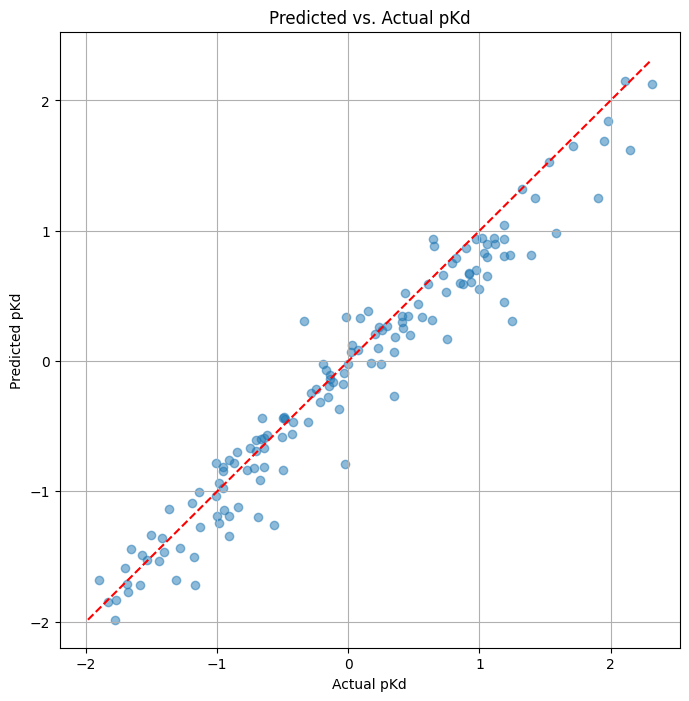

In [17]:
# prompt: make me a graph that shows the predictions and real value

import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(debug_model, test_loader, device='cpu')
